In [13]:
import dlem

import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from dlem import util
from dlem import load_model
import seaborn as sns
import cooler
import h5py
import pandas as pd
import sys
import os
from datetime import datetime

sys.path.insert(0, '/home/tis97/loopextrusion-pytorch/dlem')

import dlem.util as util

from cooltools.lib.numutils import adaptive_coarsegrain, interp_nan

dev = torch.device('cuda')

today = datetime.today().date()
date = today.strftime("%Y%m%d")


In [8]:
def weighted_mse_loss(input, target, weight=None):
    if weight is None:
        weight = torch.exp(target)
    return torch.mean(weight * (input - target) ** 2)

def wMSE_weight(weight_matrix):
    return weight_matrix


def get_fitted_parameters(model, patch_normalized , MSE_weights, diag_stop, locus, n_epochs=100):
        
    optimizer = optim.Adam(model.parameters(), lr=0.5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=25, mode="max")

    best_loss_model, best_corr_model, arr_loss, arr_corr = util.train_w_depth(model, optimizer, scheduler, loss, 
                                                                                         np.exp(patch_normalized)[np.newaxis], 
                                                                                         diag_start = int(3*10/kres) , diag_end = diag_stop, 
                                                                                         weights = weights(MSE_weights),
                                                                                         dev = dev, num_epoch=n_epochs,
                                                                                         n_predicted_diagonals=int(n_diags*10/kres))  # num_epoch must either be an input or 100
    
    content = f'''best loss: {arr_loss[-1]:.4f} (corr {arr_corr[-1]:.4f}) \t best corr: {arr_corr.max():.4f}'''
    print(content)
    
    corr_L = best_corr_model.return_parameters()[0]
    corr_R = best_corr_model.return_parameters()[1]
    
    corr_pred = best_corr_model.contact_map_prediction(torch.ones((1, patch_normalized.shape[0]), device=dev) * 1.0 ).detach().cpu().numpy()   # patch_normalized.shape[0]
    corr_pred = util.diagonal_normalize(np.log(corr_pred))
    corr_pred = corr_pred[0]

    flat_patch = patch_normalized.flatten()
    flat_pred = corr_pred.flatten()

    patch_correlation = np.corrcoef( flat_patch,flat_pred )[0,1]

    corr_total_patch = np.triu(patch_normalized) + np.tril(corr_pred)

    plt.figure()
    plt.matshow( corr_total_patch, cmap='vlag')
    plt.title(f"{locus}, corr={corr_total_patch:.2f}")
    #plt.savefig(f"{shift_dir}/{locus}_m{model_idx}_best_correlation.pdf")
    #plt.savefig(f"{shift_dir}/{locus}_m{model_idx}_best_correlation.png")
    
        
    return corr_L, corr_R


def one_patch_fit(cool, locus, detachment_rate ):

    patch_coarsegrain = adaptive_coarsegrain(cool.matrix(balance=True).fetch(locus), cool.matrix(balance=False).fetch(locus), cutoff=3, max_levels=8)
    patch_coarsegrain_interpolated = interp_nan(patch_coarsegrain)               
    patch_normalized = util.diagonal_normalize(np.log( patch_coarsegrain_interpolated[np.newaxis]) )[0]

    plt.matshow(patch_normalized, cmap='vlag')
    plt.title(f'{locus} patch normalized')
    
    this_patch_width = patch_normalized.shape[0]
    diag_stop = int(final_opt_diagonal) 
    
    L_init = np.ones(this_patch_width ) * 0.99999999
    R_init = np.ones(this_patch_width ) * 0.99999999
    detach_init = detachment_rate
    
    p_model = architecture(L_init, R_init, detach_init)

    L, R = get_fitted_parameters(p_model, patch_normalized , patch_coarsegrain_interpolated, diag_stop, locus, 100)
    #p_model, patch_normalized , patch_coarsegrain_interpolated,patch_coarsegrain_interpolated, diag_stop, 100
    
    return L, R






/Users/tina/miniforge3/envs/dlem_env/lib/python3.11/site-packages/cooltools/lib/numutils.py:1376: RuntimeWarning: invalid value encountered in divide
  val_cur = ar_cur / armask_cur


TypeError: new(): data must be a sequence (got float)

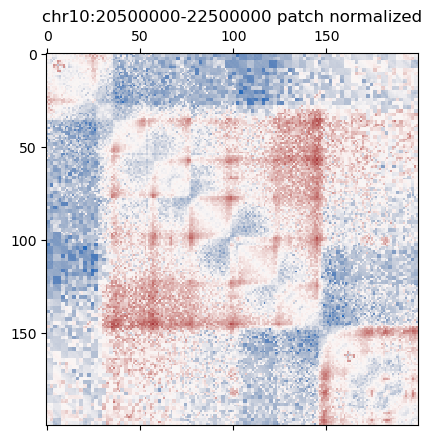

In [14]:
locus = 'chr10:20500000-22500000'
res = '10000'

detach = {'10000':0.025,
          '5000':0.00125,
          '2000':0.005}

cell_line = 'H1hESC' 
cool_filename = '/Users/tina/LoopExtrusion/data/H1.mcool'



h5 = h5py.File(cool_filename, 'r')
n_diags  = 10  

loss_type = 'wMSE'
loss = weighted_mse_loss
weights = wMSE_weight

architecture = load_model("minimal_dlem") 

intres = int(res)
cool = cooler.Cooler(h5['resolutions'][res])
kres = int( intres  / 1000)

final_opt_diagonal_bp = 1_200_000   # 2Mb 
final_opt_diagonal = int(final_opt_diagonal_bp / intres)
        
L, R = one_patch_fit(cool, locus, detach[res])
        